# Introduction to Machine Learning
## Project Phase 2
### OOD Detection and Generation with NADE
**Instructor: Dr. S. Amini**

**Farnoosh Choogani - 402100691**

**1. Dataset Preparation**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load_MNIST
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
#Binarize the data
def binarize(x):
    return (x > 0.5).float()

#Split_ID_OOD
def split_by_class(dataset, classes):
    indices = [i for i, (_, y) in enumerate(dataset) if y in classes]
    return Subset(dataset, indices)

# ID = digits 0–4
id_train_full = split_by_class(train_dataset, [0,1,2,3,4])
id_test = split_by_class(test_dataset, [0,1,2,3,4])

# OOD = digits 5–9
ood_test = split_by_class(test_dataset, [5,6,7,8,9])

#Train/Test_split
train_size = int(0.8 * len(id_train_full))
val_size = len(id_train_full) - train_size

id_train, id_val = torch.utils.data.random_split(
    id_train_full,
    [train_size, val_size]
)

batch_size = 128

train_loader = DataLoader(id_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(id_val, batch_size=batch_size)
id_test_loader = DataLoader(id_test, batch_size=batch_size)
ood_test_loader = DataLoader(ood_test, batch_size=batch_size)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.51MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 145kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.06MB/s]


**2. Task 1: Implement NADE**

In [3]:
class NADE(nn.Module):
    def __init__(self, D=784, H=500):
        super().__init__()
        self.D = D
        self.H = H
        
        self.W = nn.Parameter(torch.randn(H, D) * 0.01)
        self.V = nn.Parameter(torch.randn(D, H) * 0.01)
        self.c = nn.Parameter(torch.zeros(H))
        self.b = nn.Parameter(torch.zeros(D))
        
    def forward(self, x):
        batch_size = x.size(0)
        
        log_prob = torch.zeros(batch_size, device=x.device)
        a = self.c.unsqueeze(0).expand(batch_size, -1)
        
        for d in range(self.D):
            h = torch.sigmoid(a)
            logits = torch.matmul(h, self.V[d]) + self.b[d]
            
            log_prob += -F.binary_cross_entropy_with_logits(
                logits, x[:, d], reduction='none'
            )
            
            a = a + x[:, d].unsqueeze(1) * self.W[:, d].unsqueeze(0)
        
        return log_prob
        
#Sampling_Function
    def sample(self, n_samples):
        samples = torch.zeros(n_samples, self.D)
        a = self.c.unsqueeze(0).expand(n_samples, -1)
        
        for d in range(self.D):
            h = torch.sigmoid(a)
            logits = torch.matmul(h, self.V[d]) + self.b[d]
            probs = torch.sigmoid(logits)
            
            x_d = torch.bernoulli(probs)
            samples[:, d] = x_d
            
            a = a + x_d.unsqueeze(1) * self.W[:, d].unsqueeze(0)
        
        return samples

**3. Task 2: Training**

Epoch 1, Train: 192.0307, Val: 152.7123
Epoch 2, Train: 135.1829, Val: 124.4779
Epoch 3, Train: 115.0505, Val: 109.7754
Epoch 4, Train: 103.2653, Val: 100.4736
Epoch 5, Train: 95.5679, Val: 94.1666
Epoch 6, Train: 89.9967, Val: 89.4516
Epoch 7, Train: 85.8323, Val: 85.9480
Epoch 8, Train: 82.5644, Val: 83.0877
Epoch 9, Train: 79.9425, Val: 80.8624
Epoch 10, Train: 77.7177, Val: 79.0006
Epoch 11, Train: 75.9163, Val: 77.3628
Epoch 12, Train: 74.2991, Val: 76.1140
Epoch 13, Train: 72.9574, Val: 74.9760
Epoch 14, Train: 71.7396, Val: 73.9881
Epoch 15, Train: 70.7101, Val: 73.1143
Epoch 16, Train: 69.7870, Val: 72.3257
Epoch 17, Train: 68.9076, Val: 71.7345
Epoch 18, Train: 68.1259, Val: 71.1144
Epoch 19, Train: 67.4316, Val: 70.5579
Epoch 20, Train: 66.7784, Val: 70.1834


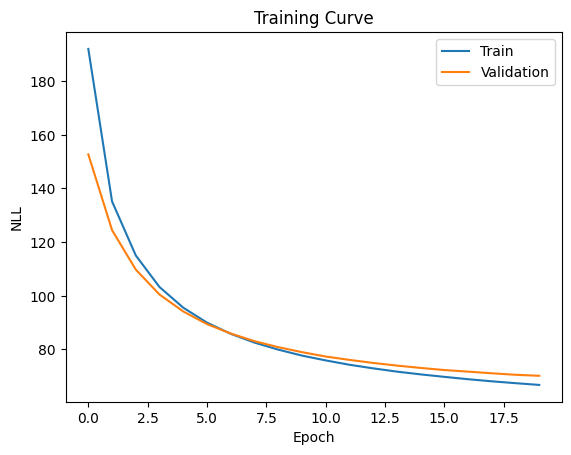

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NADE(D=784, H=500).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for x, _ in train_loader:
        x = binarize(x).view(x.size(0), -1).to(device)
        
        optimizer.zero_grad()
        log_prob = model(x)
        loss = -log_prob.mean()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    train_losses.append(total_loss / len(train_loader))
    
    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in val_loader:
            x = binarize(x).view(x.size(0), -1).to(device)
            val_loss += (-model(x).mean()).item()
    
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}, Train: {train_losses[-1]:.4f}, Val: {val_losses[-1]:.4f}")

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.title("Training Curve")
plt.show()

**4. Task 3: OOD Detection**

ID mean LL: -68.2136459350586
OOD mean LL: -99.92424774169922


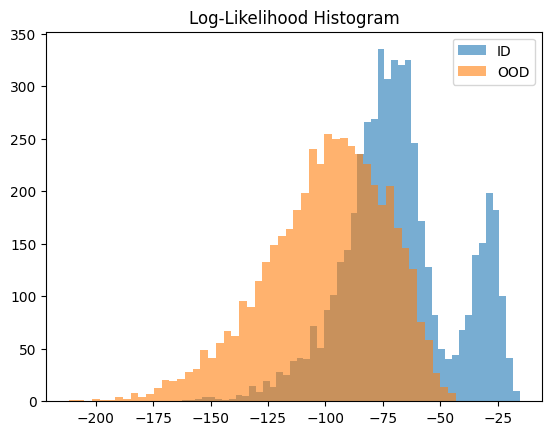

AUROC: 0.8094105648609472


In [5]:
def compute_ll(loader):
    model.eval()
    lls = []
    with torch.no_grad():
        for x, _ in loader:
            x = binarize(x).view(x.size(0), -1).to(device)
            ll = model(x)
            lls.append(ll.cpu())
    return torch.cat(lls)

id_ll = compute_ll(id_test_loader)
ood_ll = compute_ll(ood_test_loader)

print("ID mean LL:", id_ll.mean().item())
print("OOD mean LL:", ood_ll.mean().item())

#Histogram_Plots

plt.hist(id_ll.numpy(), bins=50, alpha=0.6, label="ID")
plt.hist(ood_ll.numpy(), bins=50, alpha=0.6, label="OOD")
plt.legend()
plt.title("Log-Likelihood Histogram")
plt.show()

#AUROC_Metric

from sklearn.metrics import roc_auc_score

labels = np.concatenate([
    np.zeros(len(id_ll)),
    np.ones(len(ood_ll))
])

scores = np.concatenate([
    id_ll.numpy(),
    ood_ll.numpy()
])

auroc = roc_auc_score(labels, -scores)
print("AUROC:", auroc)

***The overlaid histograms show that ID samples are generally assigned higher log-likelihoods than OOD samples. Although there is some overlap between the two distributions, the separation is clear enough to enable effective OOD detection, which is further confirmed by an AUROC of approximately 0.81.***

**5. Task 4: Generation**

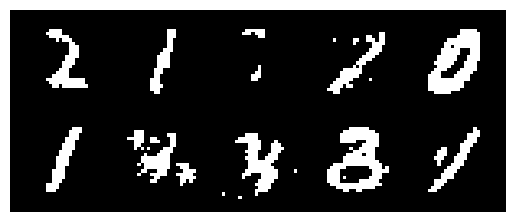

In [6]:
import torchvision.utils as vutils
samples = model.sample(10).view(-1, 1, 28, 28)
grid = vutils.make_grid(samples, nrow=5)
plt.imshow(grid.permute(1,2,0).numpy(), cmap='gray')
plt.axis("off")
plt.show()

***The generated samples clearly resemble digits from the training classes (0–4) rather than random noise, indicating that the model has successfully learned the underlying data distribution. However, the samples are somewhat blurry and imperfect, which is expected given the simplicity of NADE and its strictly sequential sampling process.***